# 1. Procesamiento y etiquetado de fondos

Vamos a trabajar con imagenes en escala de grises, cada una con dimensiones de 62 x 47 pıxeles.
Para asegurar coherencia, procesaremos las fotografıas de fondo para que compartan estas propiedades.

En total, contamos con 13.233 imagenes de rostros, de las cuales utilizaremos un 90 % para el entrenamiento, dejandonos aproximadamente 11.909 imagenes de rostros para dicho proposito

Con el objetivo de hacer que nuestro conjunto de datos refleje de manera mas precisa la realidad, donde se requerir a detectar rostros en imagenes donde la mayorıa de los parches seran fondos,hemos decidido que por cada rostro en el conjunto de entrenamiento existan 5 fondos, mientras que en el conjunto de prueba este numero se incrementa a 100.

In [37]:
import code.carga  as carga

X_train, X_test, y_train, y_test = carga.get_train_test(5, 100)

print(f'muestras entrenamiento: {X_train.shape}')
print(f'muestras validacion: {X_test.shape}')

muestras entrenamiento: (71357, 62, 47)
muestras validacion: (133521, 62, 47)


## 2. Features HOG

In [38]:
from skimage import feature, data, color
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Visualización de las HOG features')

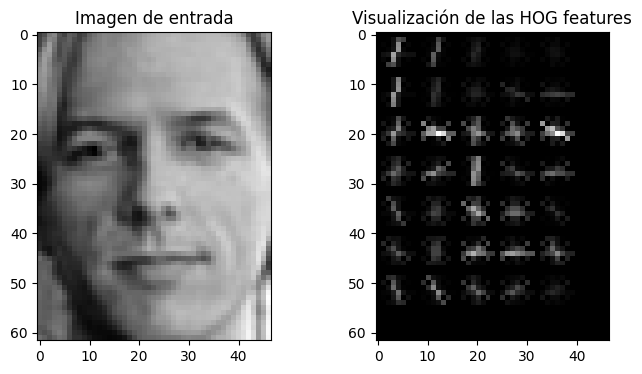

In [39]:
muestra_ejemplo = carga.positive_patches()[58]
hog_features, hog_vis = feature.hog(muestra_ejemplo, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(muestra_ejemplo, cmap='gray')
ax[0].set_title('Imagen de entrada')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('Visualización de las HOG features')

## 3. Comparacion de modelos

Entre todos los experimentos realizados, seleccionamos los 10 modelos más destacados, principalmente basándonos en sus métricas de Balanced Accuracy y FPR (tasa de falsos positivos).

Dado que nuestra meta es maximizar la detección de caras en un modelo desbalanceado, utilizamos la Balanced Accuracy y, al mismo tiempo, buscamos minimizar los falsos positivos (FPR).

In [40]:
import pandas as pd
import tabulate

path = './results/results.csv'
df = pd.read_csv(path)

# Ordenar por FPR y TPR por separado
df_ba = df.sort_values(by=['Balanced Accuracy'], ascending=False).head(100)
df_fpr = df_ba.sort_values(by=['FPR'], ascending=True).head(10)

results = []

# Iterar sobre los clasificadores en df_fpr y buscar coincidencias en df_tpr
for _, row in df_fpr.iterrows():

    # Agregar a la lista de resultados
    results.append([
        row['Classifier'],
        row['Preprocessing'],
        row['Accuracy'],
        row['Precision'],
        row['Recall/TPR'],
        row['FPR'],
        row['FNR'],
        row['TNR'],
        row['F1-Score'],
        row['ROC curve (area)'],
        row['Balanced Accuracy'],
        row['Time Train']
    ])

# Imprimir la tabla usando tabulate
headers = ["Classifier", "Preprocessing", "Accuracy", "Precision", "Recall/TPR", "FPR", "FNR", "TNR", "F1-Score", "ROC curve (area)", "Balanced Accuracy", "Time Train"]
print(tabulate.tabulate(results, headers, tablefmt="grid"))


+-------------------------------------------------------------------------------------------------------------------+-----------------+------------+-------------+--------------+-----------+-------------+----------+------------+--------------------+---------------------+--------------+
| Classifier                                                                                                        | Preprocessing   |   Accuracy |   Precision |   Recall/TPR |       FPR |         FNR |      TNR |   F1-Score |   ROC curve (area) |   Balanced Accuracy |   Time Train |
+===================================================================================================================+=================+============+=============+==============+===========+=============+==========+============+====================+=====================+==============+
| GBoostingClassifier: n_estimators: 100, loss: exponential, max_depth: 5, min_samples_split: 2, max_features: sqrt | HOGPrepocess    |   0.99

## 4. Entrenamiento y evaluación del modelo

In [41]:
from sklearn.ensemble import  GradientBoostingClassifier
import code.features as feat
from joblib import load, dump

# Entrenamos el modelo
#n_estimators: 100, loss: exponential, max_depth: 5, min_samples_split: 2, max_features: sqrt  
dt = GradientBoostingClassifier(n_estimators=100, loss='exponential', max_depth=5, min_samples_split=2, max_features='sqrt') 

X_train_prep = feat.HOGPrepocess().preprocess_imgs(X_train)
dt.fit(X_train_prep, y_train)
dump(dt, "./model/model.joblib") 

Preprocessing Images HOGPrepocess: 100%|██████████| 71357/71357 [00:11<00:00, 6292.21image/s]


['./model/model.joblib']

In [42]:
model_saved = load('./model/model.joblib')
X_test_prep = feat.HOGPrepocess().preprocess_imgs(X_test)
y_pred = model_saved.predict(X_test_prep)
y_pred_proba = model_saved.predict_proba(X_test_prep)[:,1]

Preprocessing Images HOGPrepocess: 100%|██████████| 133521/133521 [00:19<00:00, 6716.02image/s]


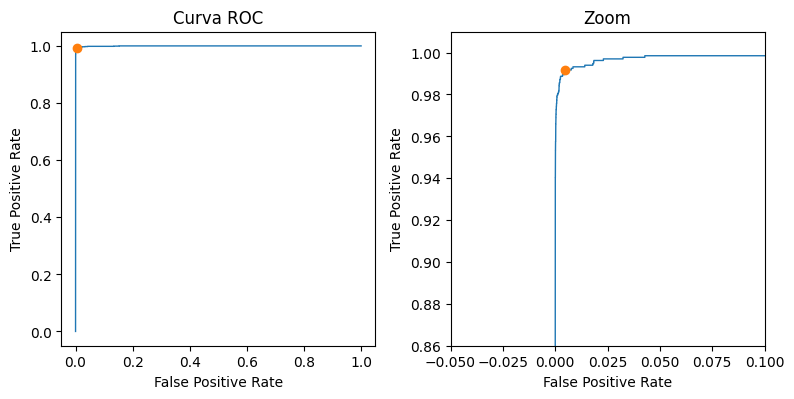

Umbral óptimo: 0.0433
FPR: 0.0049, TPR: 0.9917


In [43]:
from sklearn.metrics import roc_curve

# Curva ROC y umbral óptimo
fig, ax = plt.subplots(1,2,figsize=(8, 8))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)

ax[0].step(
    fpr,
    tpr,
    lw=1,
    alpha=1,
)

ax[0].plot(
    fprOpt,
    tprOpt,
    marker = 'o'
)

ax[0].set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Curva ROC",
)
ax[0].axis("square")

ax[1].set_aspect('equal')
ax[1].set_xlim([-0.05, 0.1])
ax[1].set_xbound(lower=-0.05, upper=0.1)
ax[1].set_ylim([0.85,1])
ax[1].set_ybound(lower=0.86, upper=1.01)

ax[1].step(
    fpr,
    tpr,
    lw=1,
    alpha=1,
)

ax[1].plot(
    fprOpt,
    tprOpt,
    marker = 'o'
)

ax[1].set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Zoom",
)

plt.tight_layout()
plt.show()

print(f'Umbral óptimo: {thresholdOpt}')
print(f'FPR: {fprOpt}, TPR: {tprOpt}')

In [44]:
# Otra forma de calcular un umbral adecuado
indx = np.argmax(tpr>=0.95)
thresholdAde = thresholds[indx]
print('Umbral adecuado: ', thresholdAde)

Umbral adecuado:  0.7781326505100885


### 4.1 Test en la imagen del astronauta

In [45]:
from skimage.transform import  rescale

# Imagen de prueba
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

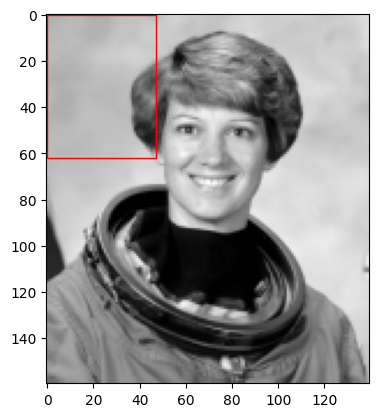

In [46]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

# Defino las dimensiones del parche
positive_patche_shape = carga.positive_patches()[0].shape
true_scale = 1
Ni, Nj = positive_patche_shape

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [47]:
import code.face_detector as detector

# Utiliza la función de ventana deslizante en una imagen de prueba.
indices, patches = zip(*detector.sliding_window(test_image, positive_patche_shape ,scale=true_scale))


# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(1911, 1215)

#### 4.1.1 Desempeño según umbrales

In [48]:
# Escalas a testear
test_scales = np.linspace(0.125, 2, 50)

In [49]:
# Predicción

# Umbral default
labels_default = model_saved.predict(patches_hog).astype(int)

# Umbral óptimo
labels_optimo = (model_saved.predict_proba(patches_hog)[:,1]>=thresholdOpt).astype(int)

# Umbral adecuado
labels_adecuado = (model_saved.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)

In [50]:
Ni, Nj = positive_patche_shape
indices = np.array(indices)

# Umbral default
detecciones_default = indices[labels_default == 1]
detecciones_default = detector.non_max_suppression(np.array(detecciones_default),Ni,Nj, 0.3)

# Umbral optimo
detecciones_optimo = indices[labels_optimo == 1]
detecciones_optimo = detector.non_max_suppression(np.array(detecciones_optimo),Ni,Nj, 0.3)

# Umbral adecuado
detecciones_adecuado = indices[labels_adecuado == 1]
detecciones_adecuado = detector.non_max_suppression(np.array(detecciones_adecuado),Ni,Nj, 0.3)

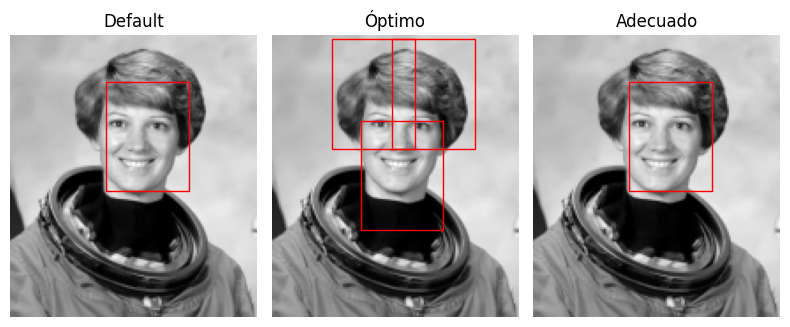

In [51]:
# Visualizamos las detecciones
fig, ax = plt.subplots(1,3, figsize=(8,4))

# Umbral default
ax[0].imshow(test_image, cmap='gray')
ax[0].axis('off')

for i, j in detecciones_default:
    ax[0].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[0].set_title('Default')

# Umbral óptimo
ax[1].imshow(test_image, cmap='gray')
ax[1].axis('off')

for i, j in detecciones_optimo:
    ax[1].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[1].set_title('Óptimo')

# Umbral adecuado
ax[2].imshow(test_image, cmap='gray')
ax[2].axis('off')

for i, j in detecciones_adecuado:
    ax[2].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[2].set_title('Adecuado')

plt.tight_layout()
plt.show()

### 4.2 Desempeño en varias escalas según umbral

In [52]:
# Escalas a testear
test_scales = np.linspace(0.125, 2, 50)

In [53]:
raw_detections, detections = detector.detections_by_scale(
    model_saved,
    test_image,
    test_scales,
    positive_shape=positive_patche_shape,
    step=2,
    thresholds=[0.5, thresholdOpt, thresholdAde]
    )

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


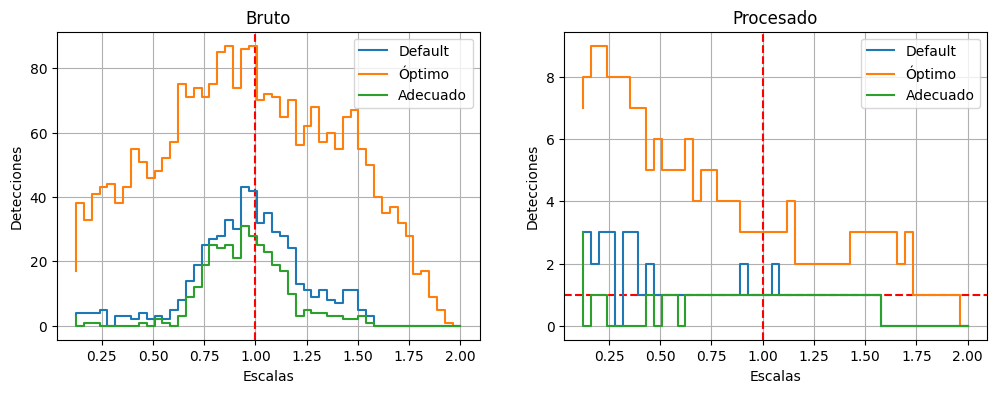

In [54]:
number_faces = 1

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Bruto')
ax[0].axvline(x=true_scale, ls = '--', color='red')
ax[0].step(test_scales, raw_detections[:,0], label = 'Default')
ax[0].step(test_scales, raw_detections[:,1], label = 'Óptimo')
ax[0].step(test_scales, raw_detections[:,2], label = 'Adecuado')
ax[0].grid(True)
ax[0].set_xlabel('Escalas')
ax[0].set_ylabel('Detecciones')
ax[0].legend()

ax[1].set_title('Procesado')
ax[1].axvline(x=true_scale, ls = '--', color='red')
ax[1].axhline(y=number_faces, ls = '--', color='red')
ax[1].step(test_scales, detections[:,0], label = 'Default')
ax[1].step(test_scales, detections[:,1], label = 'Óptimo')
ax[1].step(test_scales, detections[:,2], label = 'Adecuado')
ax[1].grid(True)
ax[1].set_xlabel('Escalas')
ax[1].set_ylabel('Detecciones')
ax[1].legend()
plt.show()

## 5. Pruebas

### 5.1 Test con 2 rostros

In [55]:
test_image = plt.imread('./imagenes/2_Rostros.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape


(336, 501)

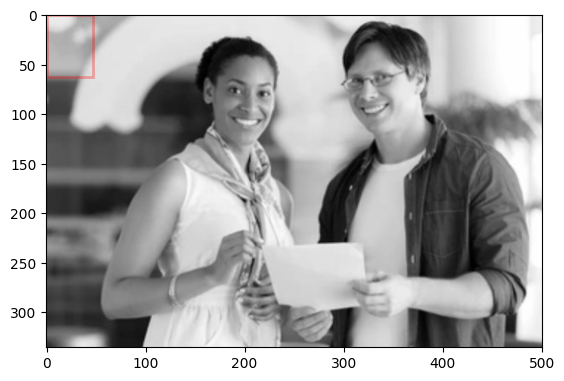

In [56]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 1.6
Ni, Nj = positive_patche_shape

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
plt.show()


In [57]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*detector.sliding_window(test_image, positive_patche_shape,scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(23919, 1215)

In [58]:
# Predicción
labels = (model_saved.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)
labels.sum()

88

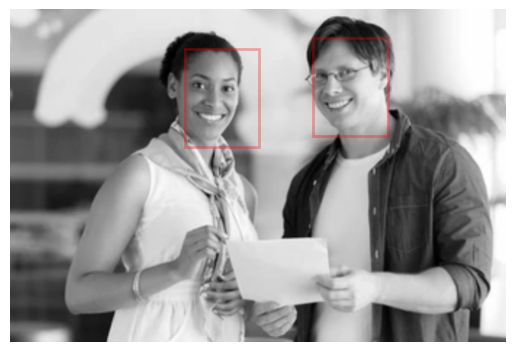

In [59]:
Ni, Nj = (int(scale*s) for s in positive_patche_shape)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = detector.non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

### 5.2 Test con 3 rostros

In [60]:
test_image = plt.imread('./imagenes/3_Rostros.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(292, 443)

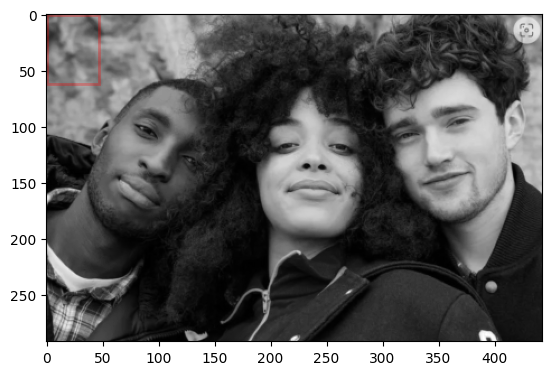

In [61]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 2.47
Ni, Nj = positive_patche_shape

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
plt.show()

In [62]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*detector.sliding_window(test_image, positive_patche_shape,scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(10150, 1215)

In [63]:
# Predicción
labels = (model_saved.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)
labels.sum()

158

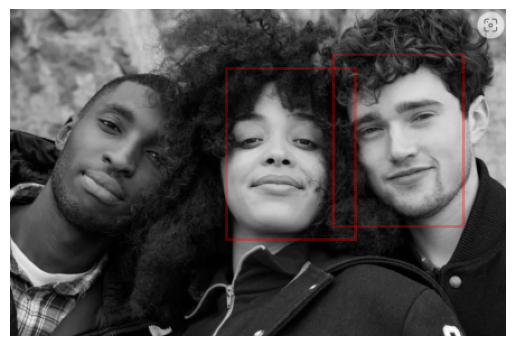

In [64]:
Ni, Nj = (int(scale*s) for s in positive_patche_shape)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = detector.non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

### 5.3 Test con muchos rostro

In [65]:
test_image = plt.imread('./imagenes/Central.jpg')
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image,0.5)
test_image.shape

(345, 512)

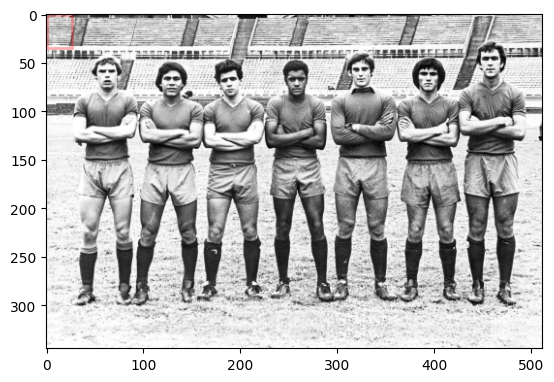

In [66]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

scale = 0.57
Ni, Nj = (int(scale * s) for s in positive_patche_shape)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
plt.show()

In [67]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*detector.sliding_window(test_image, positive_patche_shape ,scale=scale))

# Calcula las características HOG para cada parche y las almacena en un array.
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Muestra la forma del array de características HOG.
patches_hog.shape

(37045, 1215)

In [68]:
# Predicción
labels = (model_saved.predict_proba(patches_hog)[:,1]>=thresholdAde).astype(int)
labels.sum()

86

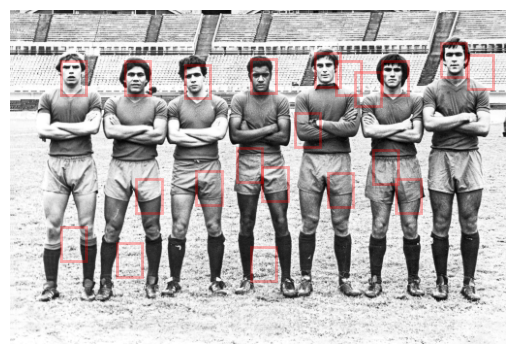

In [69]:
Ni, Nj = (int(scale*s) for s in positive_patche_shape)
indices = np.array(indices)
detecciones = indices[labels == 1]
detecciones = detector.non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)

# Visualizamos las detecciones
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i, j in detecciones:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))